In [1]:
# Cell 1: Imports and Data Loading
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1. Data Curation: Load Malaria Dataset from TensorFlow Datasets
# This satisfies the requirement for a "Public Dataset"
print("Downloading data...")
dataset, info = tfds.load('malaria', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:]'])
train_raw, test_raw = dataset[0], dataset[1]

# Define Constants
IMG_SIZE = 128
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# 2. Preprocessing (Resizing & Normalization)
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply preprocessing
train_ds = train_raw.map(preprocess).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Data loaded. Classes: {info.features['label'].names}")
# Label 0: Parasitized, Label 1: Uninfected (Note: In this dataset, usually 0=Parasitized, 1=Uninfected or vice versa. We will verify).

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.SZK3P1_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
Data loaded. Classes: ['parasitized', 'uninfected']


Sample Images (0=Parasitized, 1=Uninfected):


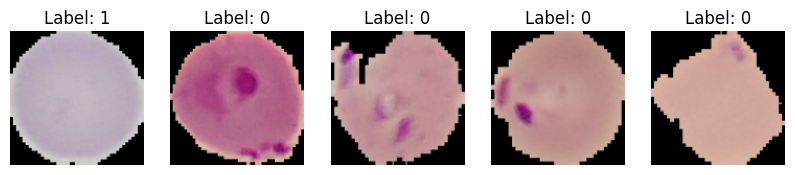

In [2]:
# Cell 2: EDA - Visualize Samples
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {int(label)}")
        plt.axis("off")
    plt.show()

print("Sample Images (0=Parasitized, 1=Uninfected):")
show_samples(train_ds)

In [3]:
# Cell 3: Baseline Model (Simple CNN)
# Requirement: "Train a simple baseline" + SAVE THIS FOR APP

from tensorflow.keras import layers, models, callbacks

def build_baseline():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        # 1st Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # 2nd Conv Block
        # We give this layer a NAME so we can find it easily for Grad-CAM later
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='last_conv'),
        layers.MaxPooling2D((2, 2)),

        # Classification Head
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid') # Binary classification
    ])
    return model

baseline_model = build_baseline()
baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Early Stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training Baseline Model...")
history_baseline = baseline_model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[early_stop])

# --- SAVE THE CNN MODEL ---
baseline_model.save('cnn_model.h5')
print("✅ Baseline CNN model saved as 'cnn_model.h5'")

Training Baseline Model...
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - accuracy: 0.6645 - loss: 0.6158 - precision: 0.6699 - recall: 0.6650 - val_accuracy: 0.9164 - val_loss: 0.2258 - val_precision: 0.9248 - val_recall: 0.9048
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9183 - loss: 0.2346 - precision: 0.9305 - recall: 0.9060 - val_accuracy: 0.9334 - val_loss: 0.1995 - val_precision: 0.9346 - val_recall: 0.9308
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9330 - loss: 0.1795 - precision: 0.9433 - recall: 0.9224 - val_accuracy: 0.9240 - val_loss: 0.2034 - val_precision: 0.9477 - val_recall: 0.8960
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9432 - loss: 0.1505 - precision: 0.9573 - recall: 0.9285 - val_accuracy: 0.9298 - val_loss: 0.2322 - val_precision: 0.9253 - val_recall: 0.9337
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9485 - loss: 0.1315 - precision: 0.9613 - recall: 0.9350 

✅ Baseline CNN model saved as 'cnn_model.h5'


In [4]:
# Cell 4: Advanced Model (Functional API Fix)
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, callbacks

def build_advanced_model():
    # 1. Setup Base Model
    base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    # 2. Build Model using Functional API (Fixes the loading error)
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # We explicitly pass inputs through the base_model
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    return model, base_model

adv_model, base_model = build_advanced_model()
adv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

print("Training Advanced Model (Frozen Base)...")
history_adv = adv_model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=[early_stop])

# Fine-Tuning
print("Fine-tuning Advanced Model...")
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

adv_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

history_finetune = adv_model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=[early_stop])

# Save the fixed model
adv_model.save('malaria_model.h5')
print("✅ Model saved successfully.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training Advanced Model (Frozen Base)...
Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - AUC: 0.8681 - accuracy: 0.7914 - loss: 0.4351 - val_AUC: 0.9756 - val_accuracy: 0.9245 - val_loss: 0.2040
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - AUC: 0.9719 - accuracy: 0.9202 - loss: 0.2117 - val_AUC: 0.9785 - val_accuracy: 0.9305 - val_loss: 0.1855
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - AUC: 0.9750 - accuracy: 0.9264 - loss: 0.1966 - val_AUC: 0.9802 - val_accuracy: 0.9332 - val_loss: 0.1776
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - AUC: 0.9773 - accuracy: 0.9294 - loss: 0.1873 - val_AUC: 0.9808 - val_accuracy: 0.9318 - val_loss: 0.1783
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - AUC: 0.9780 - accuracy: 0.9309 - loss: 0.1815 - val_AUC: 0.9808 - val_accuracy: 0.9303 - val_loss: 0.1855
Fine-tuning Advanced Model...
Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 99ms/step - AUC: 0.9809 - accu

✅ Model saved successfully.


Evaluating Baseline Model...

Baseline Model Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.93      0.94      0.93      2780
  Uninfected       0.93      0.93      0.93      2732

    accuracy                           0.93      5512
   macro avg       0.93      0.93      0.93      5512
weighted avg       0.93      0.93      0.93      5512

Evaluating Advanced Model...

Advanced Model Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2780
  Uninfected       0.95      0.97      0.96      2732

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512


=== Model Performance Comparison ===
                Accuracy  Precision    Recall  F1-Score
Baseline CNN    0.933418   0.934583  0.930820  0.932698
Advanced VGG16  0.958999   0.949426  0.968887  0.959058


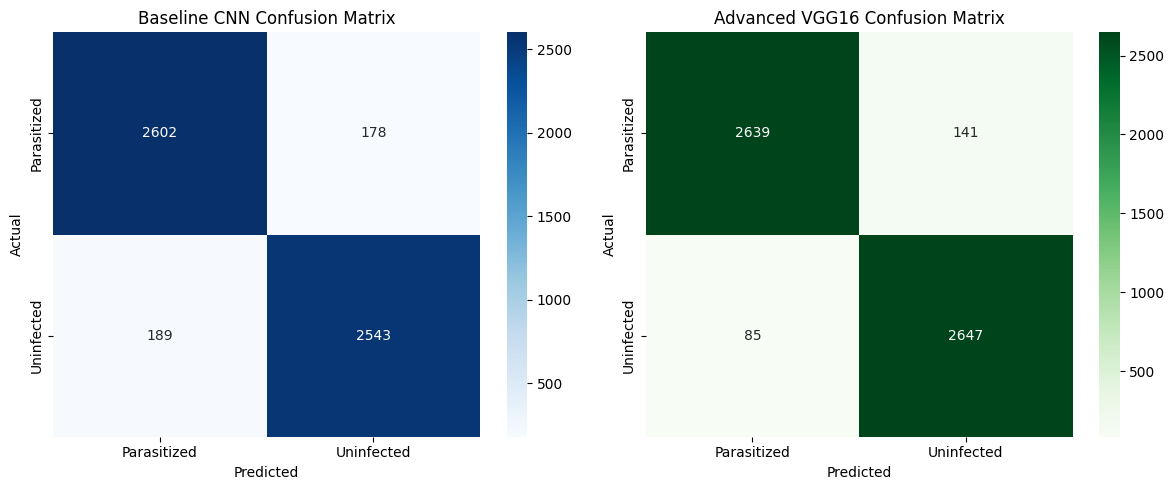

In [5]:
# Cell 5: Comprehensive Evaluation & Comparison
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Evaluate Baseline Model ---
print("Evaluating Baseline Model...")
y_true_baseline = []
y_pred_baseline = []

for img, label in test_ds:
    y_true_baseline.extend(label.numpy())
    preds_baseline = baseline_model.predict(img, verbose=0)
    y_pred_baseline.extend(np.round(preds_baseline).flatten())

print("\nBaseline Model Classification Report:")
print(classification_report(y_true_baseline, y_pred_baseline, target_names=['Parasitized', 'Uninfected']))

# --- 2. Evaluate Advanced Model (VGG16) ---
print("Evaluating Advanced Model...")
y_true_adv = []
y_pred_adv = []

for img, label in test_ds:
    y_true_adv.extend(label.numpy())
    preds_adv = adv_model.predict(img, verbose=0)
    y_pred_adv.extend(np.round(preds_adv).flatten())

print("\nAdvanced Model Classification Report:")
print(classification_report(y_true_adv, y_pred_adv, target_names=['Parasitized', 'Uninfected']))

# --- 3. Create Comparison Table (DataFrame) ---
# We define the dictionary 'metrics_data' here so the DataFrame code works
metrics_data = {
    "Baseline CNN": {
        "Accuracy": accuracy_score(y_true_baseline, y_pred_baseline),
        "Precision": precision_score(y_true_baseline, y_pred_baseline),
        "Recall": recall_score(y_true_baseline, y_pred_baseline),
        "F1-Score": f1_score(y_true_baseline, y_pred_baseline)
    },
    "Advanced VGG16": {
        "Accuracy": accuracy_score(y_true_adv, y_pred_adv),
        "Precision": precision_score(y_true_adv, y_pred_adv),
        "Recall": recall_score(y_true_adv, y_pred_adv),
        "F1-Score": f1_score(y_true_adv, y_pred_adv)
    }
}

# Convert the metrics_data dictionary to a Pandas DataFrame
df_metrics = pd.DataFrame(metrics_data).T

print("\n=== Model Performance Comparison ===")
print(df_metrics)

# --- 4. Visualize Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline Matrix
cm_base = confusion_matrix(y_true_baseline, y_pred_baseline)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
axes[0].set_title('Baseline CNN Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Advanced Matrix
cm_adv = confusion_matrix(y_true_adv, y_pred_adv)
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
axes[1].set_title('Advanced VGG16 Confusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

Generating Grad-CAM for model: sequential
Targeting layer: last_conv


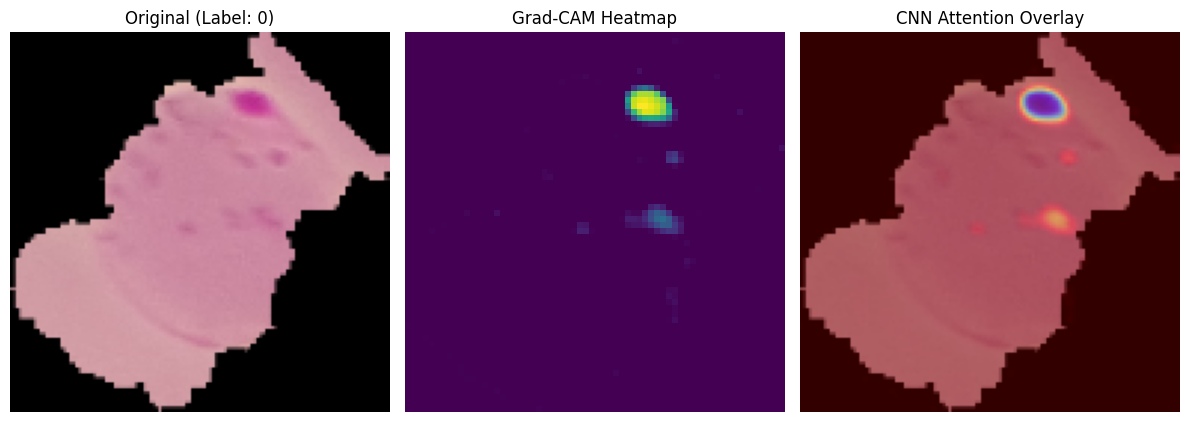

In [6]:
# Cell 6: Fixed Grad-CAM for Keras 3 Sequential Model
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Hàm này tái tạo lại graph của model Sequential để tương thích với Keras 3
    bằng cách duyệt qua các layer thay vì gọi trực tiếp .output
    """
    # 1. Tạo một Input tensor mới có cùng kích thước với ảnh đầu vào
    # img_array shape là (1, 128, 128, 3) -> input shape là (128, 128, 3)
    input_shape = img_array.shape[1:]
    inputs = tf.keras.Input(shape=input_shape)

    # 2. Dựng lại luồng xử lý (Graph) sử dụng các layer ĐÃ TRAIN của model cũ
    x = inputs
    last_conv_output = None

    for layer in model.layers:
        x = layer(x)
        # Lưu lại output khi đi qua layer conv cuối cùng mà ta nhắm tới
        if layer.name == last_conv_layer_name:
            last_conv_output = x

    # Output cuối cùng của model (lớp dự đoán)
    model_output = x

    # 3. Tạo Grad-CAM model mới từ inputs -> [last_conv_output, prediction]
    # Lúc này graph đã được kết nối rõ ràng
    grad_model = tf.keras.models.Model(inputs=inputs, outputs=[last_conv_output, model_output])

    # 4. Tính toán Gradients (Phần này giữ nguyên logic chuẩn)
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient của lớp dự đoán đối với output của lớp conv
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Global Average Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Nhân trọng số
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Chuẩn hóa
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- THỰC THI ---

# 1. Lấy ảnh mẫu
for img, label in test_ds.take(1):
    sample_img = img[0]
    sample_label = label[0]
    break

# 2. Chuẩn bị ảnh đầu vào
img_array = tf.expand_dims(sample_img, axis=0)

# 3. Cấu hình
target_model = baseline_model  # Model CNN từ Cell 3
target_layer_name = 'last_conv' # Tên layer đã đặt trong Cell 3

print(f"Generating Grad-CAM for model: {target_model.name}")
print(f"Targeting layer: {target_layer_name}")

# 4. Tạo Heatmap (Sẽ không còn lỗi AttributeError)
heatmap = make_gradcam_heatmap(img_array, target_model, target_layer_name)

# 5. Vẽ hình
plt.figure(figsize=(12, 6))

# Ảnh gốc
ax1 = plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title(f"Original (Label: {int(sample_label)})")
plt.axis('off')

# Heatmap
ax2 = plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis('off')

# Overlay
ax3 = plt.subplot(1, 3, 3)
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
sample_img_uint8 = np.uint8(255 * sample_img)
superimposed_img = cv2.addWeighted(sample_img_uint8, 0.6, heatmap_resized, 0.4, 0)

plt.imshow(superimposed_img)
plt.title("CNN Attention Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()